# Persistent/Distributed Generation with ``Crop`` Example

This example shows how to use the {class}`~xyzpy.Crop` object for disk-based
combo running - either for persistent progress or distributed processing.

First let's define a very simple function, describe it with a
{class}`~xyzpy.Runner` and {class}`~xyzpy.Harvester` and set the combos for
this first set of runs.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import xyzpy as xyz


def foo(a, b):
    return a + b, a - b


r = xyz.Runner(foo, ["sum", "diff"])
h = xyz.Harvester(r, data_name="foo_data.h5")

combos = {
    "a": range(0, 10),
    "b": range(0, 10),
}

We could use the harvester to generate data locally. But if we want results to
be written to disk, either for persistence or to run them elsewhere, we need
to create a {class}`~xyzpy.Crop`.

In [2]:
c = h.Crop(name="first_run", batchsize=5)
c

<Crop(name='first_run', batchsize=5, num_batches=20)>

## Sow the combos

A single crop is used for each set of runs/combos, with batchsize setting how many runs should be lumped together (default: 1).
We first **sow** the ``combos`` to disk using the ``Crop``:

In [3]:
c.sow_combos(combos)

100%|##########| 100/100 [00:00<00:00, 124128.56it/s]


There is now a hidden directory containing everything the crop needs:

In [4]:
!ls -a

 .				   dask-worker-space
 ..				  'farming example.ipynb'
'basic output example.ipynb'	   .ipynb_checkpoints
'complex output example.ipynb'	  'visualize linear algebra.ipynb'
'crop example.ipynb'		   .xyz-first_run
'dask distributed example.ipynb'


And inside that are folders for the batches and results, the pickled function, and some other dumped settings:

In [5]:
!ls .xyz-first_run/

batches  results  xyz-function.clpkl  xyz-settings.jbdmp


Once sown, we can check the progress of the ``Crop``:

In [6]:
print(c)


/media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples/.xyz-first_run
-------------------------------------------------------------------=========
5 / 20 batches of size 5 completed
[#####               ] : 25.0%



There are a hundred combinations, with a batchsize of 5, yielding 20 batches to be processed.

:::{hint}
As well as ``combos`` you can supply ``cases`` and ``constants`` to
{meth}`~xyzpy.Crop.sow_combos`.
:::

## Grow the results

Any python process with access to the sown batches in ``.xyz-first_run`` (and the function requirements) can grow the results (you could even zip the folder up and send elsewhere). The process can be run in several ways:

1. In the ``.xyz-first_run`` folder itself, using e.g:

```bash
python -c "import xyzpy; xyzpy.grow(i)"  # with i = 1 ... 20
```

2. In the current ('parent') folder, one then has to used a named crop to differentiate: e.g:

```bash
python -c "import xyzpy; crop=xyzpy.Crop(name='fist_run'); xyzpy.grow(i, crop=crop)"
```

3. Somewhere else. Then the parent must be specified too, e.g.:

```bash
python -c "import xyzpy; crop=xyzpy.Crop(name='first_run', parent_dir='.../xyzpy/docs/examples'); xyzpy.grow(i, crop=crop)"
```

To fake this happening we can run {class}`~xyzpy.grow` ourselves (this cell could standalone):

In [7]:
import xyzpy

crop = xyzpy.Crop(name="first_run")
for i in range(1, 11):
    xyzpy.grow(i, crop=crop)

xyzpy: loaded batch 1 of first_run.


{'a': 0, 'b': 4}: 100%|##########| 5/5 [00:00<00:00, 3460.65it/s]


xyzpy: success - batch 1 completed.
xyzpy: loaded batch 2 of first_run.


{'a': 0, 'b': 9}: 100%|##########| 5/5 [00:00<00:00, 4195.14it/s]


xyzpy: success - batch 2 completed.
xyzpy: loaded batch 3 of first_run.


{'a': 1, 'b': 4}: 100%|##########| 5/5 [00:00<00:00, 2392.64it/s]


xyzpy: success - batch 3 completed.
xyzpy: loaded batch 4 of first_run.


{'a': 1, 'b': 9}: 100%|##########| 5/5 [00:00<00:00, 4371.80it/s]


xyzpy: success - batch 4 completed.
xyzpy: loaded batch 5 of first_run.


{'a': 2, 'b': 4}: 100%|##########| 5/5 [00:00<00:00, 4623.35it/s]


xyzpy: success - batch 5 completed.
xyzpy: loaded batch 6 of first_run.


{'a': 2, 'b': 9}: 100%|##########| 5/5 [00:00<00:00, 3317.75it/s]


xyzpy: success - batch 6 completed.
xyzpy: loaded batch 7 of first_run.


{'a': 3, 'b': 4}: 100%|##########| 5/5 [00:00<00:00, 3296.37it/s]


xyzpy: success - batch 7 completed.
xyzpy: loaded batch 8 of first_run.


{'a': 3, 'b': 9}: 100%|##########| 5/5 [00:00<00:00, 4092.00it/s]


xyzpy: success - batch 8 completed.
xyzpy: loaded batch 9 of first_run.


{'a': 4, 'b': 4}: 100%|##########| 5/5 [00:00<00:00, 2017.66it/s]


xyzpy: success - batch 9 completed.
xyzpy: loaded batch 10 of first_run.


{'a': 4, 'b': 9}: 100%|##########| 5/5 [00:00<00:00, 4612.17it/s]

xyzpy: success - batch 10 completed.


And now we can check the progress:

In [8]:
print(c)


/media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples/.xyz-first_run
-------------------------------------------------------------------=========
10 / 20 batches of size 5 completed
[##########          ] : 50.0%



If we were on a batch system we could use {meth}`xyzpy.Crop.grow_cluster` to automatically
submit all missing batches as jobs. It is worth double checking the script that
is used first though! This is done using {meth}`xyzpy.Crop.gen_cluster_script`:

In [9]:
print(c.gen_cluster_script(scheduler="sge", minutes=20, gigabytes=1))

#!/bin/bash -l
#$ -S /bin/bash
#$ -N first_run
#$ -l h_rt=0:20:0,mem=1G
#$ -l tmpfs=1G
mkdir -p /home/johnnie/Scratch/output
#$ -wd /home/johnnie/Scratch/output
#$ -pe smp None

#$ -t 1-10
echo 'XYZPY script starting...'
cd /media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples
export OMP_NUM_THREADS=None
export MKL_NUM_THREADS=None
export OPENBLAS_NUM_THREADS=None
export NUMBA_NUM_THREADS=None

conda activate py311
read -r -d '' SCRIPT << EOM
#
from xyzpy.gen.cropping import grow, Crop
if __name__ == '__main__':
    crop = Crop(name='first_run', parent_dir='/media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples')
    print('Growing:', repr(crop))
    grow_kwargs = dict(crop=crop, debugging=False, num_workers=None)
    batch_ids = (11, 12, 13, 14, 15, 16, 17, 18, 19, 20)]
    grow(batch_ids[$SGE_TASK_ID - 1], **grow_kwargs)
EOM
python -c "$SCRIPT"
echo 'XYZPY script finished'



The default ``scheduler`` is ``'sge'`` (Sun Grid Engine),
however you can also specify ``'pbs'`` (Portable Batch System)
or ``'slurm'``:

In [10]:
print(c.gen_cluster_script(scheduler="pbs", minutes=20, gigabytes=1))

#!/bin/bash -l
#PBS -N first_run
#PBS -lselect=None:ncpus=None:mem=1gb
#PBS -lwalltime=00:20:00

#PBS -J 1-10
echo 'XYZPY script starting...'
cd /media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples
export OMP_NUM_THREADS=None
export MKL_NUM_THREADS=None
export OPENBLAS_NUM_THREADS=None
export NUMBA_NUM_THREADS=None

conda activate py311
read -r -d '' SCRIPT << EOM
#
from xyzpy.gen.cropping import grow, Crop
if __name__ == '__main__':
    crop = Crop(name='first_run', parent_dir='/media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples')
    print('Growing:', repr(crop))
    grow_kwargs = dict(crop=crop, debugging=False, num_workers=None)
    batch_ids = (11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
    grow(batch_ids[$PBS_ARRAY_INDEX - 1], **grow_kwargs)
EOM
python -c "$SCRIPT"
echo 'XYZPY script finished'



In [11]:
print(c.gen_cluster_script(scheduler="slurm", minutes=20, gigabytes=1))

#!/bin/bash -l
#SBATCH --job-name=first_run
#SBATCH --time=00:20:00
#SBATCH --mem=1G
#SBATCH --array=1-10
echo 'XYZPY script starting...'
cd /media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples
export OMP_NUM_THREADS=None
export MKL_NUM_THREADS=None
export OPENBLAS_NUM_THREADS=None
export NUMBA_NUM_THREADS=None

conda activate py311
read -r -d '' SCRIPT << EOM
#
from xyzpy.gen.cropping import grow, Crop
if __name__ == '__main__':
    crop = Crop(name='first_run', parent_dir='/media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples')
    print('Growing:', repr(crop))
    grow_kwargs = dict(crop=crop, debugging=False, num_workers=None)
    batch_ids = (11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
    grow(batch_ids[$SLURM_ARRAY_TASK_ID - 1], **grow_kwargs)
EOM
python -c "$SCRIPT"
echo 'XYZPY script finished'



If you are just using the ``Crop`` as a persistence mechanism,
then {meth}`xyzpy.Crop.grow` or {meth}`xyzpy.Crop.grow_missing`
will process the batches in the current process:

In [12]:
c.grow_missing(parallel=True)  #  this accepts combo_runner kwargs

100%|##########| 10/10 [00:00<00:00, 19.46it/s]


In [13]:
print(c)


/media/johnnie/Storage2TB/Sync/dev/python/xyzpy/docs/examples/.xyz-first_run
-------------------------------------------------------------------=========
20 / 20 batches of size 5 completed
[####################] : 100.0%



:::{hint}
If different function calls might take different amounts of time based on their arguments,
you can supply ``shuffle=True`` to {meth}`xyzpy.Crop.sow_combos`. Each batch will then
be a random selection of cases, which should even out the effort each takes as long as
``batchsize`` is not too small.
:::

## Reap the results

The final step is to **'reap'** the results from disk. Because the crop was instantiated from a ``Harvester``, that harvester will be automatically used to collect the resulting dataset and sync it with the on-disk dataset:

In [14]:
c.reap()

100%|##########| 100/100 [00:00<00:00, 193196.87it/s]


<xarray.Dataset>
Dimensions:  (a: 10, b: 10)
Coordinates:
  * a        (a) int64 0 1 2 3 4 5 6 7 8 9
  * b        (b) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    sum      (a, b) int64 0 1 2 3 4 5 6 7 8 9 1 ... 9 10 11 12 13 14 15 16 17 18
    diff     (a, b) int64 0 -1 -2 -3 -4 -5 -6 -7 -8 -9 1 ... 9 8 7 6 5 4 3 2 1 0

:::{hint}
If the ``Crop`` is incomplete but has some results, you can call `crop.reap(allow_incomplete=True)` to harvest the existing data.
:::

:::{hint}
You can supply other kwargs related to harvesting such as ``overwrite=True``, which is useful when you want to replace existing data with newer runs without starting over.
:::

The dataset `foo_data.h5` should be on disk, and the crop folder cleaned up:

In [15]:
!ls -a

 .				   dask-worker-space
 ..				  'farming example.ipynb'
'basic output example.ipynb'	   foo_data.h5
'complex output example.ipynb'	   .ipynb_checkpoints
'crop example.ipynb'		  'visualize linear algebra.ipynb'
'dask distributed example.ipynb'


And we can inspect the results:

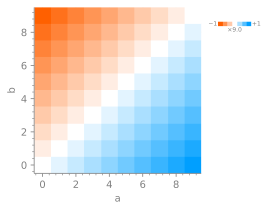

In [16]:
h.full_ds.xyz.plot(x="a", y="b", z="diff");

Many crops can be created from the harvester at once, and when they are reaped, the results should be seamlessly combined into the on-disk dataset.

In [17]:
# for now clean up
h.delete_ds()